In [1]:
# Import required packages
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] ="false"
import jax
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
import matplotlib


In [2]:
seed = 1
rng = jax.random.PRNGKey(seed)
key_sample, rng_params, rng = jax.random.split(rng, 3)
low  = jnp.array([0.0, 0.0])
high = jnp.array([1.0, 1.0])
from learning.agents.sampler_ppo.distributions import make_adr_update_fn,\
      get_adr_sample, plot_adr_density_2d
init_fn, adr_update = make_adr_update_fn(
    domain_low=low,
    domain_high=high,
    success_threshold=0.5,
    expansion_factor=1.1,
)
state = init_fn()
adr_update_fn = jax.jit(adr_update)


W1226 16:10:09.219427 1471223 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1226 16:10:09.222311 1471066 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Saved GIF to adr_training.gif


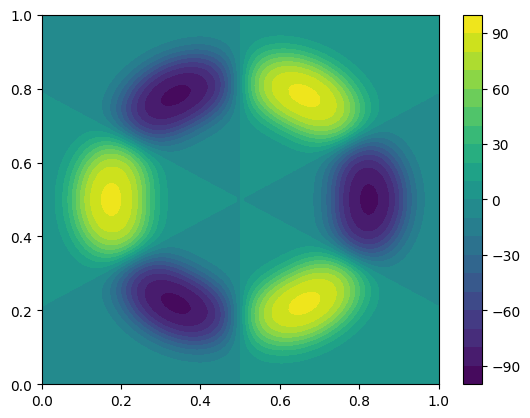

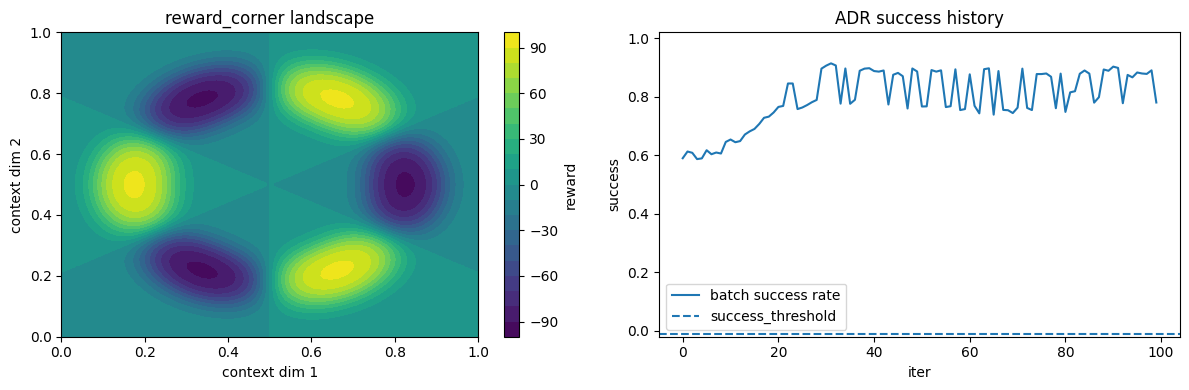

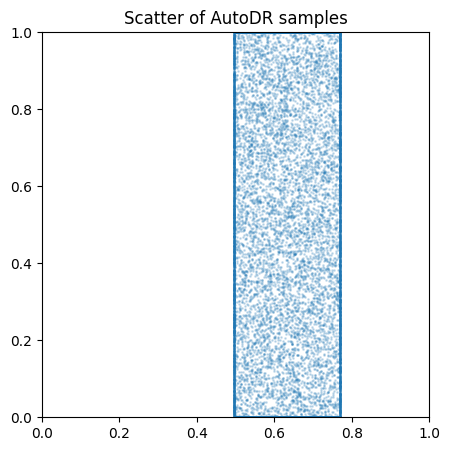

In [12]:
import jax, jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import imageio
from learning.agents.sampler_ppo.distributions import make_adr_update_fn,\
      get_adr_sample, plot_adr_density_2d

def reward_corner(contexts, target=jnp.array([0.3, 0.7]), sigma=0.12, noise_std=0.2, key=None):
    # reward in [0,1], peaked near target
    diff = contexts - target[None, :]
    r = jnp.exp(-0.5 * jnp.sum((diff / sigma) ** 2, axis=-1))
    if key is not None:
        r = jnp.clip(r + noise_std * jax.random.normal(key, r.shape), 0.0, 1.0)
    return r
low  = jnp.array([0.0, 0.0])
high = jnp.array([1.0, 1.0])
beta= 100
def target3(z):
    m=3
    r0=0.65
    sr=0.12
    X, Y = jnp.split(z, 2, axis=-1)
    x = 2.0 * (X - 0.5)
    y = 2.0 * (Y - 0.5)
    r = jnp.hypot(x, y)
    theta = jnp.arctan2(y, x)

    ring = jnp.exp(-0.5 * ((r - r0) / sr) ** 2)
    petals = jnp.cos(m * theta)
    U = jnp.tanh(1.6 * (ring * petals))  # bounded in (-1, 1)
    log_unnorm = -beta * U.squeeze() 
    # --- 3. Combine ---
    return log_unnorm
def run_toy_corner():
    success_threshold      = -0.01 

    init_fn, adr_update = make_adr_update_fn(
        domain_low=low,
        domain_high=high,
        success_threshold=success_threshold,
        expansion_factor=1.1,
    )
    state = init_fn()
    adr_update_fn = jax.jit(adr_update)
    x, y = jnp.meshgrid(jnp.linspace(low[0], high[0], 100), jnp.linspace(low[1], high[1], 100))
    grid = jnp.c_[x.ravel(), y.ravel()]
    # pdf_values = reward_corner(grid)
    pdf_values = target3(grid)
    pdf_values = jnp.reshape(pdf_values, x.shape)
    T = 100

    N = 2048
    snap_iters = [0, 1, 2, 5, 10, 15, 24] + list(range(30, T, 10))
    
    succ_hist = []
    key = jax.random.PRNGKey(0)
    gif_frames = [] 
    for t in range(T):
        kc, kx, kr, kplot, key = jax.random.split(key, 5)

        contexts = get_adr_sample(state, N, kc)
        # returns  = reward_corner(contexts, key=kr)
        returns = target3(contexts)
        succ = jnp.mean((returns >= success_threshold).astype(jnp.float32))

        succ_hist.append(float(succ))

        if t in snap_iters:
            fig, (ax_reward, ax_adr) = plt.subplots(1, 2, figsize=(10, 4))
            ctf = ax_reward.contourf(x, y, pdf_values, levels=20)
            ax_reward.set_title("reward_corner landscape")
            ax_reward.set_xlabel("context dim 1")
            ax_reward.set_ylabel("context dim 2")
            fig.colorbar(ctf, ax=ax_reward, label="reward")
            ax_adr = plot_adr_density_2d(
                state, low, high, kplot, ax=ax_adr
            )
            ax_adr.set_title(f"ADR training distribution (iter {t})")
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.asarray(fig.canvas.buffer_rgba())[..., :3]
            gif_frames.append(frame)
            plt.close(fig)

        state = adr_update_fn(state, contexts, returns, kx)

    if gif_frames:
        imageio.mimsave("adr_training.gif", gif_frames, fps=4)
        print("Saved GIF to adr_training.gif")
    # Parameter trajectories
    it = np.arange(T)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Left: reward_corner pdf contourf
    ax0 = axes[0]
    ctf = ax0.contourf(x, y, pdf_values, levels=20)
    ax0.set_title("reward_corner landscape")
    ax0.set_xlabel("context dim 1")
    ax0.set_ylabel("context dim 2")
    fig.colorbar(ctf, ax=ax0, label="reward")

    # Right: success history with threshold
    ax1 = axes[1]
    ax1.plot(it, succ_hist, label="batch success rate")
    ax1.axhline(success_threshold, linestyle="--", label="success_threshold")
    ax1.set_xlabel("iter")
    ax1.set_ylabel("success")
    ax1.set_ylim(-0.02, 1.02)
    ax1.legend()
    ax1.set_title("ADR success history")

    plt.tight_layout()
    plt.show()
    plt.close()
    key = jax.random.PRNGKey(0)
    contexts = get_adr_sample(state, 2**14, kc)
    x_np = np.array(contexts)
    np.save(f"autodr_samples_beta={beta}.npy", x_np)
    # 1) Raw scatter plot (no binning)
    plt.figure(figsize=(5, 5))
    plt.scatter(x_np[:, 0], x_np[:, 1], s=1, alpha=0.2)
    plt.xlim(low[0], high[0])
    plt.ylim(low[1], high[1])
    plt.title("Scatter of AutoDR samples")
    plt.savefig(f"AutoDR_image_beta={beta}.png")
    plt.show()

x, y = jnp.meshgrid(jnp.linspace(low[0], high[0], 100), jnp.linspace(low[1], high[1], 100))
grid = jnp.c_[x.ravel(), y.ravel()]
pdf_values = reward_corner(grid)
pdf_values = target3(grid)
pdf_values = jnp.reshape(pdf_values, x.shape)
fig = plt.figure()
ctf = plt.contourf(x, y, pdf_values, levels=20, cmap='viridis')
cbar = fig.colorbar(ctf)
run_toy_corner()


In [4]:
pdf_values.max()

Array(92.13237, dtype=float32)